<a href="https://colab.research.google.com/github/wbandabarragan/Bootcamp2025/blob/main/CursoB_Semana2/Machine_Learning/ISYA2025_MLcourse_Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Lab: A simple neural network to classify astronomical

In this lab you will learn how to use torch to create a simple neural network model that classifies astronomical objects between two classes: quasi-stellar objects (QSOs) and galaxies, according to their observed properties. These properties are the fluxes (light intensities) measured with a telescope using different filters, and the distance to the object, as measured by the "redshift", $z$. Most of the code here is based on a TensorFlow example by Vihar Kurama, translated to torch by RMG.

### SDSS colors
The Sloan Digital Sky Survey is a project that uses a few telescopes and instruments to measure the brightness and motions of stars and galaxies. It observes objects using different color filters, and those different colors can be used to infer the type of the object, in a similar way as you can tell the temperature of an steel bar by looking at its color when it is being heated. We will code up a logistic regression model that will learn to distinguish between galaxies and QSOs by looking at these colors, as well as the distance to the galaxies (images taken from the astroML and scikit-learn projects).


### Loading the dataset
We start by doing the relevant imports first. We will use pandas to manipulate our dataset, which is a list of colors and redshifts measured for many objects in the sky, and tensorflow as our main tool for doing automatic differentiation and building the logistic regression:

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

The dataset is a table containing one row for each object. The columns are the magnitudes (you can think of magnitudes as an indication of brightness) in the different SDSS "colors" or "filters": $u, g, r, i, z$. In addition to the magnitudes, the redshift ($z1$) is an indication of the distante to the object, and $z_{\rm{err}}$ measures its error. There is also a label, which indicates the class of the object (either QSO or galaxy). These labels will be our target quantities in the classification exercise. Let's load the dataset using pandas. We convert the data type of the numerical values from 64-bit floats to 32-bit float.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Skyserver_SQL6_13_2022_6_01_53_PM.csv to Skyserver_SQL6_13_2022_6_01_53_PM.csv


In [ ]:
data = pd.read_csv('Skyserver_SQL6_13_2022_6_01_53_PM.csv')
float_cols = [c for c in data if data[c].dtype == "float64"]
float32_cols = {c: np.float32 for c in float_cols}
data = pd.read_csv('Skyserver_SQL6_13_2022_6_01_53_PM.csv', engine='c', dtype=float32_cols)

In [ ]:
data

,u,g,r,i,z,label,z1,zerr
0,17.882219,15.960280,15.061700,14.596340,14.262910,GALAXY,0.024328,0.000007
1,18.563690,16.723270,15.796230,15.370910,15.001250,GALAXY,0.070124,0.000012
2,19.294109,17.502300,16.586491,16.163031,15.813410,GALAXY,0.049190,0.000015
3,19.333590,17.437780,16.458441,15.999580,15.668430,GALAXY,0.080963,0.000011
4,18.928631,18.661831,18.277420,18.222160,18.330410,QSO,1.234354,0.000313
...,...,...,...,...,...,...,...,...
49995,19.443760,18.168680,17.611271,17.234631,17.036989,GALAXY,0.081990,0.000009
49996,19.362280,19.319090,19.318140,19.133801,18.812941,QSO,2.115130,0.000132
49997,19.423420,18.056681,17.134609,16.649920,16.467159,GALAXY,0.131247,0.000015
49998,18.588011,17.442011,16.938610,16.577280,16.421881,GALAXY,0.082057,0.000008


There are 50,000 objects in the dataset. However, QSOs are underepresented in the dataset, accounting for just about 16% of the entire dataset. Classe that are underrepresented in a gvie dataset can be difficult to classify, and so we keep only a similar number of galaxies and QSOs, by making the sample of galaxies smaller. The resulting dataset has about 15,000 objects.

In [ ]:
df_galaxies = data.loc[data['label'] == 'GALAXY'][0:8000]
df_qsos = data.loc[data['label'] == 'QSO']

frames = [df_galaxies, df_qsos]

data = pd.concat(frames)

data = data.sample(frac=1)

In [ ]:
data

,u,g,r,i,z,label,z1,zerr
6412,17.762980,15.811250,14.852740,14.390330,14.040280,GALAXY,0.063456,0.000014
21153,18.420710,18.297880,18.184099,18.024050,18.083099,QSO,1.635814,0.000156
7933,18.522320,17.337940,16.837170,16.534290,16.321079,GALAXY,0.037400,0.000010
2188,19.394449,17.698790,16.811171,16.371490,16.053230,GALAXY,0.107533,0.000020
3945,18.216209,16.708851,15.979550,15.533940,15.244430,GALAXY,0.068176,0.000015
...,...,...,...,...,...,...,...,...
5769,18.088779,16.160271,15.091390,14.631730,14.263700,GALAXY,0.114194,0.000023
17266,19.122480,18.923679,18.847750,18.675560,18.675051,QSO,1.801483,0.000592
16328,19.013130,18.841881,18.756451,18.558201,18.510630,QSO,1.723883,0.000263
2787,18.886110,17.161190,16.396681,16.023430,15.731640,GALAXY,0.028538,0.000014


### Visualizing the dataset

We now visualize the features that we will use to classify between the two types of objects. The plots below show that the two types are well separated in some of the features, and not in others. In particular, we plot the color-color diagrams $u-g$ vs. $g-r$, $r-i$ vs. $i-z$, as well as these colors compared with the redshift distribution. Note that QSOs tend to have redder colors with respect to galaxies. This is because they caan be hevaily obscured by dust and have less recent star formation, and hence, less young. massive, blue stars. There is, however some overlap between the two types and the decision bondaries are not necessaily linear.

Text(0, 0.5, 'redshift error')

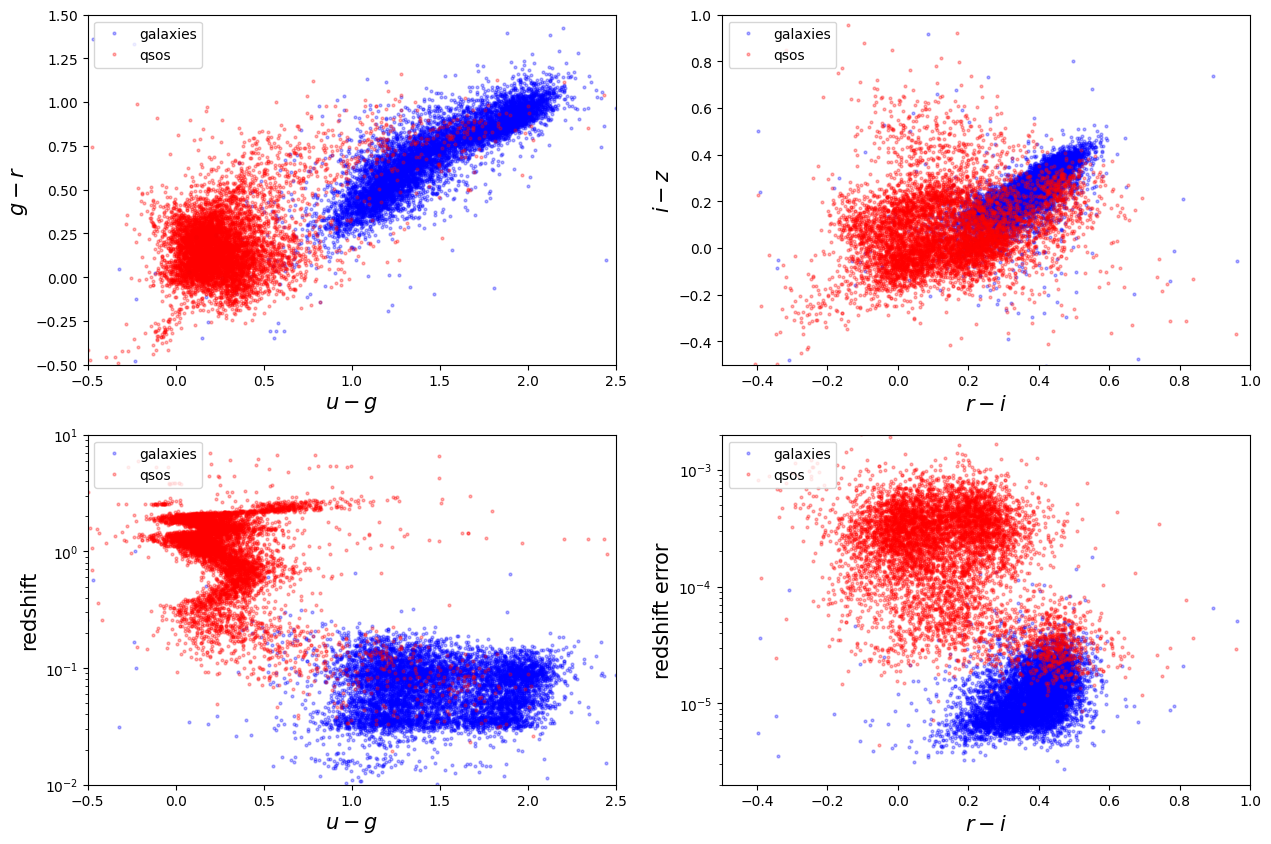

In [ ]:
# Extract colors and spectral class
ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']
spec_class = data['label']

galaxies = (spec_class == 'GALAXY')
qsos = (spec_class == 'QSO')


fig, axs = plt.subplots(2, 2,figsize = (15,10))
axs[0, 0].plot(ug[galaxies], gr[galaxies], '.', ms=4, c='b', label='galaxies',alpha=0.3)
axs[0, 0].plot(ug[qsos], gr[qsos], '.', ms=4, c='r', label='qsos',alpha=0.3)
axs[0, 0].set_xlim(-0.5, 2.5)
axs[0, 0].set_ylim(-0.5, 1.5)
axs[0, 0].legend(loc=2)
axs[0, 0].set_xlabel('$u-g$',size=15)
axs[0, 0].set_ylabel('$g-r$',size=15)
axs[0, 1].plot(ri[galaxies], iz[galaxies], '.', ms=4, c='b', label='galaxies',alpha=0.3)
axs[0, 1].plot(ri[qsos], iz[qsos], '.', ms=4, c='r', label='qsos',alpha=0.3)
axs[0, 1].set_xlim(-0.5, 1.0)
axs[0, 1].set_ylim(-0.5, 1.0)
axs[0, 1].legend(loc=2)
axs[0, 1].set_xlabel('$r-i$',size=15)
axs[0, 1].set_ylabel('$i-z$',size=15)
axs[1, 0].plot(ug[galaxies], data['z1'][galaxies], '.', ms=4, c='b', label='galaxies',alpha=0.3)
axs[1, 0].plot(ug[qsos], data['z1'][qsos], '.', ms=4, c='r', label='qsos',alpha=0.3)
axs[1, 0].set_yscale('log')
axs[1, 0].set_xlim(-0.5, 2.5)
axs[1, 0].set_ylim(0.01, 10.0)
axs[1, 0].legend(loc=2)
axs[1, 0].set_xlabel('$u-g$',size=15)
axs[1, 0].set_ylabel('redshift',size=15)
axs[1, 1].plot(ri[galaxies], data['zerr'][galaxies], '.', ms=4, c='b', label='galaxies',alpha=0.3)
axs[1, 1].plot(ri[qsos], data['zerr'][qsos], '.', ms=4, c='r', label='qsos',alpha=0.3)
axs[1, 1].set_yscale('log')
axs[1, 1].set_xlim(-0.5, 1.0)
axs[1, 1].set_ylim(0.000002, 0.002)
axs[1, 1].legend(loc=2)
axs[1, 1].set_xlabel('$r-i$',size=15)
axs[1, 1].set_ylabel('redshift error',size=15)

#for ax in axs.flat:
#    ax.set(xlabel='u-g', ylabel='z')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# Create color features
ug = data['u'] - data['g']
gr = data['g'] - data['r']
ri = data['r'] - data['i']
iz = data['i'] - data['z']
z1 = data['z1']


# Combine features into a single numpy array
features = np.stack([ug, gr, ri, iz, z1], axis=1).astype(np.float32)

# Use var_target for labels
labels = var_target.values


# Split data
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
# Convert y_train to long tensor
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val)
# Convert y_val to long tensor
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Define MLP model
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        # Adjusted input layer to match the number of features
        self.net = nn.Sequential(
            nn.Linear(5, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)  # Two classes: GALAXY and QSO
        )

    def forward(self, x):
        return self.net(x)

# Initialize model, loss function, optimizer
model = MLPClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    correct = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            output = model(batch_x)
            pred = output.argmax(dim=1)
            correct += (pred == batch_y).sum().item()
    val_acc = correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}, Val Acc = {val_acc:.4f}")

Epoch 1: Loss = 0.4380, Val Acc = 0.9437
Epoch 2: Loss = 0.1389, Val Acc = 0.9679
Epoch 3: Loss = 0.1016, Val Acc = 0.9748
Epoch 4: Loss = 0.0916, Val Acc = 0.9755
Epoch 5: Loss = 0.0869, Val Acc = 0.9765
Epoch 6: Loss = 0.0834, Val Acc = 0.9768
Epoch 7: Loss = 0.0811, Val Acc = 0.9778
Epoch 8: Loss = 0.0794, Val Acc = 0.9768
Epoch 9: Loss = 0.0783, Val Acc = 0.9788
Epoch 10: Loss = 0.0770, Val Acc = 0.9785
Epoch 11: Loss = 0.0761, Val Acc = 0.9785
Epoch 12: Loss = 0.0753, Val Acc = 0.9791
Epoch 13: Loss = 0.0747, Val Acc = 0.9791
Epoch 14: Loss = 0.0739, Val Acc = 0.9791
Epoch 15: Loss = 0.0729, Val Acc = 0.9795
Epoch 16: Loss = 0.0721, Val Acc = 0.9798
Epoch 17: Loss = 0.0712, Val Acc = 0.9801
Epoch 18: Loss = 0.0703, Val Acc = 0.9805
Epoch 19: Loss = 0.0698, Val Acc = 0.9805
Epoch 20: Loss = 0.0691, Val Acc = 0.9798


**Some proposed exercises**

*Exercise 1*

Task:
Train the MLPClassifier using different learning rates (0.1, 0.01, 0.001, 0.0001) and two optimizers: SGD and Adam. For each combination:

Plot the training loss and validation accuracy across 20 epochs.

Determine which optimizer and learning rate yield the best performance.

Explain what happens when the learning rate is too large or too small.

\
\

*Exercise 2*

Task:
Modify the architecture of the MLP by changing the number of hidden layers and number of neurons. Try the following architectures:

Small network: [5 → 4 → 2]

Medium network: [5 → 16 → 8 → 2] (current)

Larger network: [5 → 64 → 32 → 16 → 2]

For each architecture:

Train for 20 epochs.

Plot training loss and validation accuracy.

Observe signs of underfitting, good fit, or overfitting.

Which model generalizes best?
